# Autoregressive Point-Processes as Latent State-Space Models

## Configure notebook

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from __future__ import division
from __future__ import print_function

# Load scipy/numpy/matplotlib
from   scipy.linalg import expm
import matplotlib.pyplot as plt
from   pylab import *

# Configure figure resolution
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['savefig.dpi'   ] = 100

from izh       import * # Routines for sampling Izhikevich neurons
from plot      import * # Misc. plotting routines
from glm       import * # GLM fitting
from arppglm   import * # Sampling and integration
from utilities import * # Other utilities

figure_prefix = "RuleSanguinetti2018_figure_"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Case study: phasic bursting Izhikevich neuron

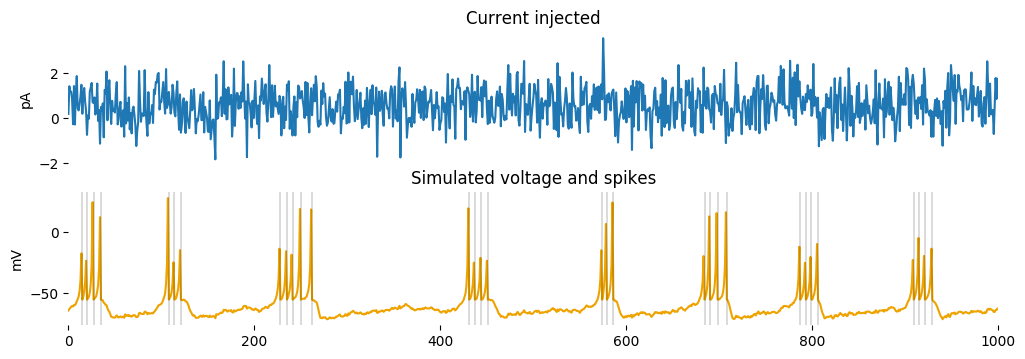

In [3]:
# Izhikevich parameters
izh = (0.02,0.25,-55,0.05) # a, b, c, d
dt  = 1.0

nplot = 1000   # time points for plotting

# Generate constant drive with synaptic noise
I = 0.6
stimulus = randn(nplot)*sqrt(I)+I

# Plot current input
subplot(311); plot(stimulus)
xlim(0,nplot); nox(); noaxis(); ylabel('pA')
title('Current injected')

# Solve Izh model
state = sim_izh(*izh,stimulus)

# Plot voltage and spikes
subplot(312); plot(state[:,1],color=OCHRE);
xlim(0,nplot); noaxis(); addspikes(state[:,-1]); ylabel('mV');
title('Simulated voltage and spikes');

## Train model on pulses

GLMs can emulate neural firing, but have limited ability to generalize outside of the dynamical regime in which they are trained (Weber & Pillow 2017). For this reason, we train with stimuli that elicit phasic bursting responses (tonic bursting seems to be possible at higher stimulation currents, but interferes with the GLMs ability to model the phasic bursting regime).

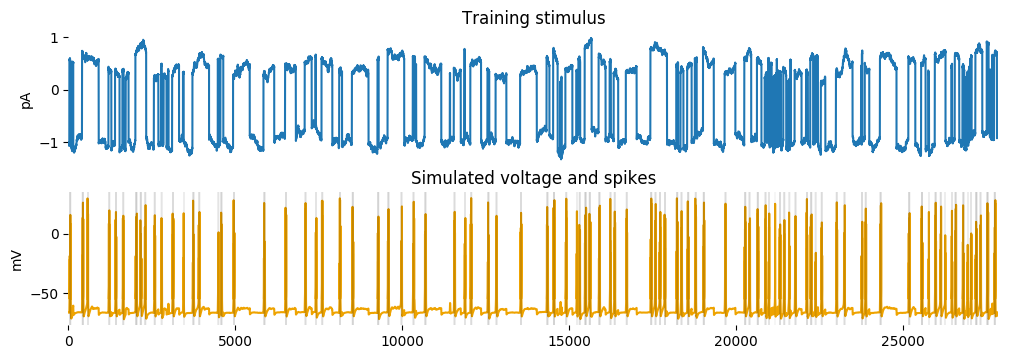

In [4]:
# Define pulse training stimuli
offset     = -1     # Baseline current (picoamps)
min_amp    = 0.3    # Smallest current step (picoamps)
max_amp    = 0.7    # Largest  current step (picoamps)
min_pulse  = 10     # Shortest pulse duration (ms)
max_pulse  = 500    # Longest  pulse duration (ms)
amplitudes = exp(linspace(log(min_amp),log(max_amp),10))
durationms = int32(exp(linspace(log(min_pulse),log(max_pulse),10)))
stimulus   = pulse_sequence(amplitudes,durationms,offset)

# Define Ornstein–Uhlenbeck (OU) process training noise 
ssvar     = 0.01           # Noise steady-state viariance (ln(pA)^2)
tau       = 200            # Noise correlation time constant (ms)
noisevar  = 2*ssvar/tau    # Noise fluctuation variance
sigma     = sqrt(noisevar) # Noise flucutation standard deviation
stimulus  += sample_ou_process(0,sigma,tau,dt,len(stimulus),ntrial=1).ravel()

ntrain     = len(stimulus)

# Plot training stimulus
subplot(311); plot(stimulus)
nox(); noaxis(); xlim(0,ntrain); ylabel('pA')
title('Training stimulus');

# Solve Izh model and get voltage and spikes
state = sim_izh(*izh,stimulus,dt=dt)
v,Y   = state[:,1],state[:,2]

# Plot voltage and spikes
subplot(312); plot(v,color=OCHRE); addspikes(Y,lw=0.05);
noaxis(); xlim(0,ntrain); ylabel('mV');
title('Simulated voltage and spikes');

# Fit GLM to Izhikevich model

### Define history basis functions

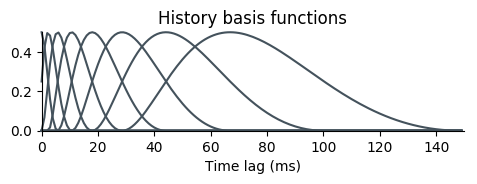

In [5]:
# Define history basis functions
N = 150   # Duration of history filter
K = 8     # number of basis elements
D = 5     # Duration of shortest basis element
B = make_cosine_basis(K,N,D,normalize=False)

# Plot history basis functions
subplot(421)
plot(B.T,color=BLACK,clip_on=False);
xlim(0,N); ylim(0,0.5); simpleaxis()
xlabel('Time lag (ms)')
title('History basis functions')

### Generate stimulus and spiking history training features

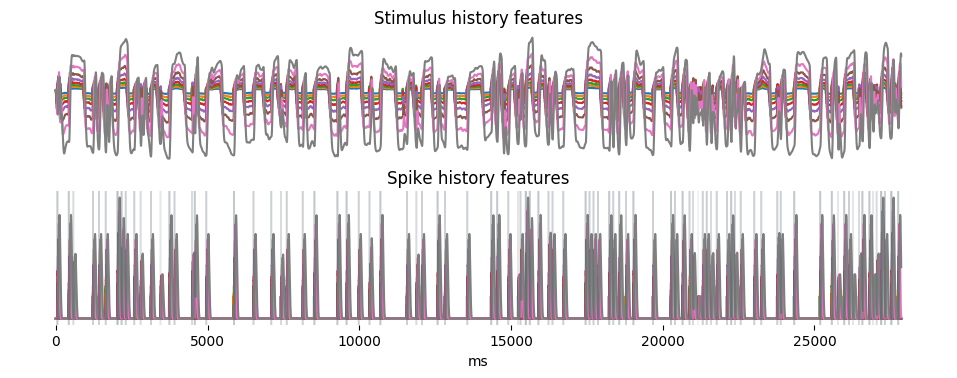

In [6]:
# Build stimulus filter (history trace of I)
# These are needed to model subthreshold dynamics
Bh = array([convolve(b,stimulus) for b in B]).T[:ntrain]
Bp = concatenate([zeros((K,1)),B],axis=1)
By = array([convolve(b,Y) for b in Bp]).T[:ntrain]

# Plot stimulus history features
subplot(311); plot(Bh); noxyaxes();
title('Stimulus history features');

# Plot spike history features
subplot(312); plot(By);
for t in find(Y>0): axvline(t,lw=0.1,color=BLACK)
noaxis(); noy(); xlabel('ms');
title('Spike history features');

## Train model

In [7]:
# Compose feature vector and fit GLM
X = concatenate([By,Bh],axis=1)
m,bhat = fitGLM(X,Y)

bhat_spikehist = bhat[:K]
bhat_stimulus  = bhat[K:]
beta = bhat[:K].reshape(K,1)

### Pulse stimulus for demonstration

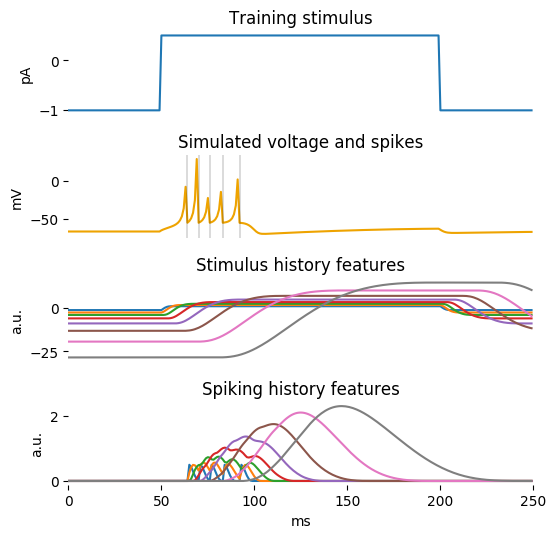

In [8]:
# define demo pulse
duration = 150  # Pulse duration (ms)
padding  = 50   # Pulse padding (ms)
burnin   = 200  # Time for Izhikevich model to settle (ms)
current  = 0.5  # Pulse current (pA)
ndemo    = duration + 2*padding # total length of demo stimulus (ms)

# Build demo stimulus
demo_stimulus = zeros(ndemo+burnin) + offset
demo_stimulus[burnin+padding:burnin+padding+duration] = current

figure(figsize=(6,6))

# Plot demo stimulus
subplot(411); plot(demo_stimulus[burnin:])
nox(); noaxis(); xlim(0,ndemo); ylabel('pA')
title('Training stimulus');

# Solve Izh model
demo_state = sim_izh(*izh,demo_stimulus,dt=dt)
demo_v = demo_state[burnin:,1]
demo_Y = demo_state[burnin:,2]

# Plot demo model spiking 
subplot(412); plot(demo_v,color=OCHRE);
addspikes(demo_Y)
nox(); noaxis(); xlim(0,ndemo); ylabel('mV');
title('Simulated voltage and spikes');

# Bulid GLM filter responses
demo_Bh = array([convolve(b,demo_stimulus) for b in B ]).T[burnin-1:][:ndemo,:]
demo_By = array([convolve(b,demo_Y       ) for b in Bp]).T[:ndemo,:]
demo_X  = concatenate([demo_By,demo_Bh],axis=1)

# Plot demo stimulus history features 
subplot(413); plot(demo_Bh);
xlim(0,ndemo); nox(); noaxis(); ylabel('a.u.')
title('Stimulus history features')

# Plot demo spiking history features 
subplot(414); plot(demo_By);
xlim(0,ndemo); noaxis(); xlabel('ms'); ylabel('a.u.')
title('Spiking history features')
subplots_adjust(hspace=0.5)
plt.draw()

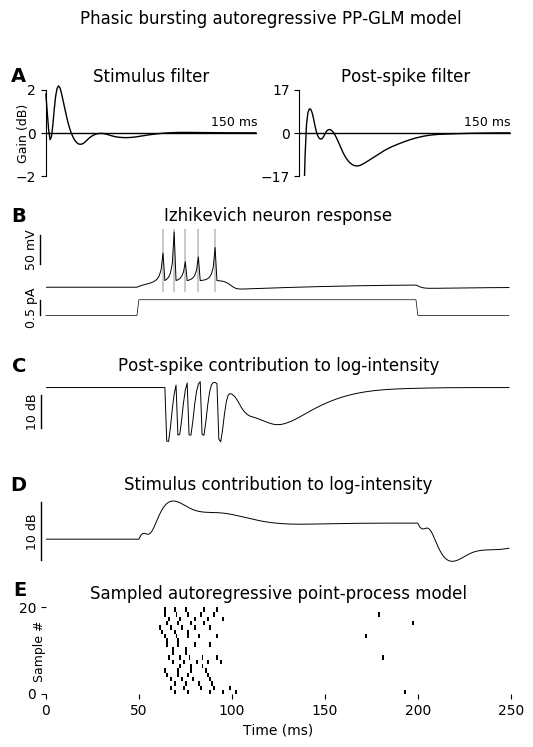

In [9]:
figure(figsize=(6,8))
# Use dB for log-units
dB    = log10(e)*10

def labeltime():
    text(xlim()[1],0+pixels_to_yunits(5),'%d ms'%N,
        horizontalalignment='right',
        verticalalignment='bottom',
        fontsize=9)

# Plot stimulus history filter
stimyscale = 2
a1=subplot2grid((5,2),(0,0),colspan=1)
plot(bhat_stimulus.dot(B)*dB,color='k',lw=1,clip_on=False)
axhline(0,color='k',lw=1)
xlim(0,N); ylim(-stimyscale,stimyscale); nox(); nicey(); simpleraxis();
ylabel('Gain (dB)',fontsize=9); fudgey(10); labeltime()
title('Stimulus filter')
subfigurelabel('A')

# Plot spike history filter
histyscale = 17
a1=subplot2grid((5,2),(0,1),colspan=1)
plot(bhat_spikehist.dot(B)*dB,color='k',lw=1)
axhline(0,color='k',lw=1)
xlim(0,N); ylim(-histyscale,histyscale); nox(); nicey(); simpleraxis(); labeltime()
title('Post-spike filter')

# Illustrate neuron stimulus and response
a2=subplot2grid((5,2),(1,0),colspan=2)
plot(demo_v,'k',lw=0.7)
draw()
yl = ylim()
for t in find(demo_Y)-1:
    plot([t,t],yl,color='k',lw=0.3)
height = abs(diff(yl)*0.25)
lower  = yl[0]-height*1.5
ii     = demo_stimulus[burnin:][:ndemo]
ii     = (ii-min(ii))/(max(ii)-min(ii))
plot(ii*height+lower,color='k',lw=0.5,clip_on=False)
yscalebar(yl[1]-35,50,'50 mV'); 
yscalebar(height*0.5+lower,height,'%0.1f pA'%current)
xlim(0,ndemo); ylim(lower,yl[1]); noxyaxes()
title('Izhikevich neuron response')
subfigurelabel('B')

# Spike history contribution
a3=subplot2grid((5,2),(2,0),colspan=2)
plot(bhat_spikehist.dot(demo_By.T),color='k',lw=0.7)
xlim(0,ndemo); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes()
title('Post-spike contribution to log-intensity')
subfigurelabel('C')

# Stimulus contribution
a4=subplot2grid((5,2),(3,0),colspan=2)
plot(bhat_stimulus.dot(demo_Bh.T),color='k',lw=0.7)
xlim(0,ndemo); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes()
title('Stimulus contribution to log-intensity')
subfigurelabel('D')

# Sample the spiking response of the GLM
a5=subplot2grid((5,2),(4,0),colspan=2)
nsample = 20
stim = m + bhat_stimulus.dot(demo_Bh.T)
ysamp,logratesamp = ensemble_sample(stim,B,beta,nsample)
pcolormesh(1-ysamp.T,cmap="gray")
noaxis(); xticks(arange(0,251,50)); yticks([0,nsample],['0','%s'%nsample])
xlabel('Time (ms)'); ylabel('Sample #',fontsize=9); fudgey(20)
title('Sampled autoregressive point-process model')
subfigurelabel('E',dy=10)

# Make final adjustments
plt.draw()
subplots_adjust(hspace=0.5)
nudge_axis_y(-10,a2); adjust_axis_height_pixels(20,a3); 
nudge_axis_y(-10,a3); adjust_axis_height_pixels(20,a4)
suptitle('Phasic bursting autoregressive PP-GLM model')

savefig(figure_prefix+'1.pdf',transparent=True,bbox_inches='tight')

# Construct low-dimensional system for history process

If the history basis is chosen suitably, the resuling linear system closely approximates the history basis. One can also use a linear system for the history filter form the outset, e.g. a collection of decaying exponential basis functions, enabeling an exact model. Since histor bases are commonly used, and the filtering approach is discussed elsewhere, we demonstrate the low-dimensional delay-line projection here. 

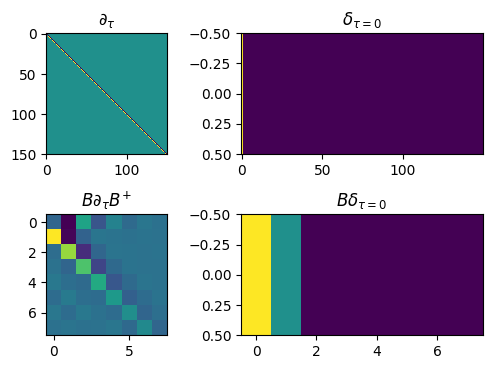

In [10]:
# Create discrete differentiation operator
Dtau = -eye(N) + eye(N,k=-1)
# Create delta operator (to inject signal into delay line)
S = zeros((N,1))
S[0,0] = 1
# Perform a change of basis from function space into the basis projection B
A = B.dot(Dtau).dot(pinv(B))
C = B.dot(S)

figure(figsize=(8,4))
subplot(221); imshow(Dtau)
title('$\partial_\\tau$')
subplot(222); imshow(S.T,aspect=N/2)
title('$\delta_{\\tau=0}$')
subplot(223); imshow(A)
title('$B \partial_\\tau B^{+}$')
subplot(224)
imshow(C.T,aspect=K/2)
title('$B \delta_{\\tau=0}$')
subplots_adjust(hspace=0.5,wspace=-0.3)

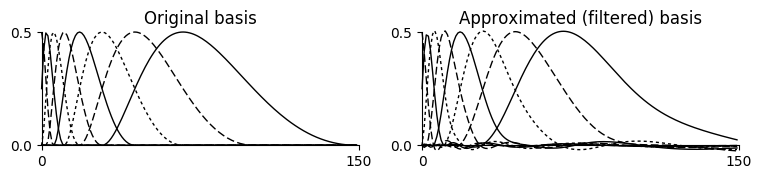

In [11]:
figure(figsize=(9,1.5))
styles = ['--','-',':']

impulse = zeros(N)
impulse[0]=1

subplot(121)
for i,b in enumerate(array([convolve(b,impulse) for b in B])):
    plot(b[:N],lw=1,linestyle=styles[i%len(styles)],color='k',clip_on=False)
simpleaxis(); xlim(0,N); ylim(0,.5); nicexy()
title('Original basis')

filtered = linfilter(A,C,impulse)
subplot(122)
for i,b in enumerate(filtered.T):
    plot(b[:N],lw=1,linestyle=styles[i%len(styles)],color='k',clip_on=False)
simpleaxis(); xlim(0,N); ylim(0,.5); nicexy()
title('Approximated (filtered) basis')

savefig(figure_prefix+'2.pdf',transparent=True,bbox_inches='tight')

# Estimate single-time marginal log-intensity and varience using several different procedures



In [12]:
# "True" sample from point process model
demo_logxpp,demo_logvpp,_,_ = ensemble_sample_moments(stim,B,beta,M=10000)
demo_lxpp = box_filter(demo_logxpp,5)
demo_lvpp = box_filter(demo_logvpp,5)

# Sample from langevin approximation of point process
demo_logxlv,demo_logvlv,_,_  = langevin_sample_moments(stim,A,beta,C,M=10000)
demo_lxlv = box_filter(demo_logxlv,5)
demo_lvlv = box_filter(demo_logvlv,5)

In [13]:
# Estimate moments from mean-field and linear noise approximation
demo_logxmf,demo_logvmf,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "LNA",
                                                int_method = "euler")

# Only first two moments of rate are used for filtering
demo_logxso,demo_logvso,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "second_order",
                                                int_method = "euler")
# Estimate using moment closure
demo_logxmc,demo_logvmc,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "moment_closure",
                                                int_method = "euler")
# Estimate using moment closure
demo_logxgg,demo_logvgg,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "gamma_matched",
                                                int_method = "euler")
# Estimate using moment closure
demo_logxgq,demo_logvgq,_,_ = integrate_moments(stim,A,beta,C,
                                                method     = "gamma_approximate",
                                                int_method = "euler")

NameError: name 'mpl' is not defined

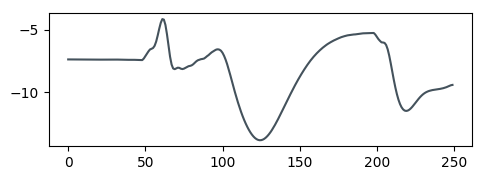

In [14]:
figure(figsize=(12,6))

# Plot sampled point process against sampled Langevin
subplot(321)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_lxlv,demo_lvlv,RUST,filled=0)
xlim(0,ndemo); noxyaxes()
title('Langevin')

# Plot LNA against sampled Langevin
subplot(322)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmf,demo_logvmf,OCHRE,filled=0)
xlim(0,ndemo); noxyaxes()
title('Mean-field, linear noise approximation')

# Plot moment-closure against sampled Langevin
subplot(323)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmc,demo_logvmc,AZURE,filled=0)
xlim(0,ndemo); noy(); noxyaxes()
title('Gaussian moment-closure')

# Plot second-order against sampled Langevin
subplot(324)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxso,demo_logvso,TURQUOISE,filled=0)
xlim(0,ndemo); noy(); noxyaxes();
title('Second-order approximation')

# Plot gamma moment matching against sampled Langevin
subplot(325)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxgg,demo_logvgg,MAUVE,filled=0)
xlim(0,ndemo); noy(); noaxis(); xlabel('Time (ms)')
title('Gamma moment matching')

# Plot approximate gamma moment matching sampled Langevin
subplot(326)
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxgq,demo_logvgq,CRIMSON,filled=0)
xlim(0,ndemo); noy(); noaxis(); xlabel('Time (ms)')
title('Approximate gamma moment matching')

subplots_adjust(wspace=0.1,hspace=0.2)

# Demonstration pulse sequence

Construct a more "naturalistic" intput stimulus

In [ ]:
# Random pulse sequence
offset     = -0.5
pulse_stimulus = pulse_sequence(linspace(0.4,1.0,4),int32(linspace(5,200,4)),offset)

# OU process defining additional Gaussian noise
ntrain = len(pulse_stimulus)
ssvar    = 0.5
tau      = 100
noisevar = 2*ssvar/tau
sigma    = sqrt(noisevar)
noise2   = sample_ou_process(0,sigma,tau,dt,ntrain,ntrial=1).ravel()

# Combine pulses with noise, apply synaptic filter
stimulus = pulse_stimulus + noise2
#stimulus = convolve(stimulus,synapse,'valid')
nstim    = 1000
stimulus = stimulus[:nstim*2]

# Plot
subplot(411); plot(stimulus[nstim:])
xlim(0,nstim); ylabel('pA'); noaxis(); nox()
title('Stimulus')

# Solve Izh model
state = sim_izh(*izh,stimulus,dt=dt)
v     = state[:,1][nstim:]
Y      = state[:,2][nstim:]
subplot(312); plot(v,color=OCHRE);
addspikes(Y)
xlim(0,nstim); noaxis(); nox()
title('Simulated voltage and spikes');
ylabel('mV');

stimulus = stimulus[nstim:]

# Build stimulus filter (history trace of I)
# These are needed to model subthreshold dynamics
demo_Bh = array([convolve(b,stimulus) for b in B ]).T[:nstim]
demo_By = array([convolve(b,Y)        for b in Bp]).T[:nstim,:]

# Plot stimulus history features
subplot(313); plot(demo_Bh); 
xlim(0,nstim); noaxis(); xlabel('Time (ms)')
title('Stimulus history features')

# Demonstrate moment-closure approximation of the AR-PP-GLM

In [ ]:
# Filtered stimulus with offset
stim = m + bhat_stimulus.dot(demo_Bh.T)

# "True" sample from point process model
logxpp,logvpp,ratepp,ratevpp = ensemble_sample_moments(stim,B,beta,M=1000)
lxpp = box_filter(logxpp,5)
lvpp = box_filter(logvpp,5)

# Sample from langevin approximation of point process
logxlv,logvlv,expmlv,expvlv  = langevin_sample_moments(stim,A,beta,C,M=1000)
lxlv = box_filter(logxlv,5)
lvlv = box_filter(logvlv,5)

# Estimate moments from expansion to second order 
# Only first two moments of rate are used for filtering
logxso,logvso,M1so,M2so = integrate_moments(stim,A,beta,C,
                                            method     = "second_order",
                                            int_method = "euler")
# Estimate moments from expansion to second order 
logxmc,logvmc,M1mc,M2m = integrate_moments(stim,A,beta,C,
                                           method     = "moment_closure",
                                           int_method = "euler")

In [ ]:
figure(figsize=(8,8))

NROWS = 5

def stimmarks():
    axvline(padding,color=(0.5,)*3,lw=0.5)
    axvline(ndemo-padding,color=(0.5,)*3,lw=0.5)

# Plot second-order approximation
subplot2grid((NROWS,2),(1,1),facecolor=(1,1,1,0))
stderrplot(demo_lxpp  ,demo_lvpp  ,BLACK    ,filled=1)
stderrplot(demo_logxso,demo_logvso,TURQUOISE,filled=0)
stimmarks(); xlim(0,ndemo); noy(); noaxis()
yl = ylim()
xlabel('Time (ms)')
title('Second order')
subfigurelabel('D')
    
# Plot true sampled GLM against Langevin sampled GLM
subplot2grid((NROWS,2),(0,0),facecolor=(1,1,1,0))
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_lxlv,demo_lvlv,RUST ,filled=0)
stimmarks(); ylim(*yl); xlim(0,ndemo); noxyaxes()
yscalebar(mean(ylim())/dB,10/dB,'10 dB'); 
title('Langevin approximation')
subfigurelabel('A')

# Plot mean-field LNA solution for moments
subplot2grid((NROWS,2),(0,1),facecolor=(1,1,1,0))
stderrplot(demo_lxpp  ,demo_lvpp  ,BLACK,filled=1)
stderrplot(demo_logxmf,demo_logvmf,OCHRE,filled=0)
stimmarks(); ylim(*yl); xlim(0,ndemo); noxyaxes(); simpleraxis()
title('Mean-field, LNA')
subfigurelabel('B')

# Plot moment closure moments
subplot2grid((NROWS,2),(1,0),facecolor=(1,1,1,0))
stderrplot(demo_lxpp,demo_lvpp,BLACK,filled=1)
stderrplot(demo_logxmc,demo_logvmc,AZURE,filled=0)
stimmarks(); ylim(*yl); xlim(0,ndemo); noy(); noaxis()
xlabel('Time (ms)')
title('Gaussian moment-closure')
subfigurelabel('C')

# Illustrate Izh neuron response and stimulus
sc = 20
ax4=subplot2grid((NROWS,2),(2,0),colspan=2,facecolor=(1,1,1,0))
plot(v,color=RUST)
xlim(0,nstim)
yscalebar(min(v)+25,50,'50 mV')
ss = (stimulus-min(stimulus))*sc + ylim()[1]+30
plot(ss,color=BLACK,lw=1)
yscalebar(mean(ss),sc*2,'2 pA'); noxyaxes()
title('Stimulus example')
subfigurelabel('E')

# Plot stimulus
ax5=subplot2grid((NROWS,2),(3,0),colspan=2,facecolor=(1,1,1,0))
stderrplot(lxpp,lvpp,BLACK,filled=1)
stderrplot(logxso,logvso,TURQUOISE,filled=0)
xlim(0,nstim); yscalebar(mean(ylim()),10,'10 dB'); noxyaxes(); 

# Plot sampled
ax6=subplot2grid((NROWS,2),(4,0),colspan=2,facecolor=(1,1,1,0))
nsamp = 20
p = np.random.poisson(exp(langevin_sample(stim,A,beta,C,M=nsamp)))
pcolormesh(-int32(p.T>0),cmap='gray')
noaxis(); 
xticks(arange(0,1001,100)); 
yticks([-0.5,nsamp-0.5],['1','%d'%nsamp])
xlabel('Time (ms)'); ylabel('Sample'); fudgey(20)

subplots_adjust(wspace=0.1,hspace=0.3)
nudge_axis_y(-75,ax4)
nudge_axis_y(-45,ax5)
adjust_axis_height_pixels(20,ax6)

savefig(figure_prefix+'4.pdf',transparent=True,bbox_inches='tight',format='pdf')